## Part IV: LDA Topic Modeling

*Note: This is part of a series on the computational analysis of open-ended survey questions. You can find the other posts in this series here: 
- "Part I: Writing Open-Ended Survey Questions for Computational Analysis" 
- "Part II: Preparing Text for Analysis” 
- "Part III: Detecting Near Duplicate Text & Named Entity Recognition" 

If you read our previous posts, you may remember that Evolytics was asked to analyze approximately 68,000 open-ended responses to nine survey questions.  These questions included asking survey participants to list competitor brands they had tried, rate the competitors, and describe their rationale for the rating. They also asked what the consumer liked about the brand and why they would recommend it.  In this post, we'll demonstrate how to create a topic model that summarizes the content of a large number of documents and how you might use this for further analysis. 

#### Installing Gensim
We're going to use the [Gensim](https://radimrehurek.com/gensim/) library to create our topic models.  Gensim has several algorithms and metrics for the evaluation of the models. If you do not have it installed you can run the cell below to install it directly in Anaconda.  

In [ ]:
# installing gensim in case I decide to do some topic modeling. 
!conda install -c anaconda gensim -y
!pip install python-Levenshtein

## What's a topic model anyway? 

Topic modeling algorithms generate statistical models of a document collection (i.e., corpus) by grouping commonly co-occurring words together so that the themes, or "topics", are revealed.  Perhaps the most well-known topic modeling algorithm is Latent Dirichlet Allocation (LDA).  I don't want to seem "hand wavy" but there are lots of articles and papers that discuss [how LDA works in detail](https://www.youtube.com/watch?v=DDq3OVp9dNA) and this is more of a practical demonstration.  Suffice to say, it is a Bayesian technique that assumes there are latent (i.e., hidden/unknown) topics that are represented by the corpus's vocabulary (i.e., the set of all modeled terms/tokens drawn from the documents).  In a gross simplification, the algorithm essentially iterates over the documents updating the probability regarding whether a given term belongs to a particular topic on each iteration.     

There are two outputs of interest from LDA models.  First, it produces a set of topics which are defined as probability distributions of the corpus's vocabulary.  Each term from the corpus's vocabulary appears in every topic but an analyst would inspect the most probable terms to get some idea regarding the nature of the topic.  Second, LDA topic models produce a document X topic matrix showing the degree to which each topic characterizes a document.  Note that topic models *do not* classify documents!  Instead, it is assumed that documents are a proportion of all the model's topics.  This makes intuitive sense - a survey response might be *both* about a products aesthetics and it's build quality.  LDA represents this mix of topics proportionately.            

## The Data 

Topic models work best when you have a large number of sufficiently long documents. In other words, a few strings a notebook cell won't cut it and I can't use our client's survey data for confidentiality reasons.  Therefore, we're going to use a dataset that I collected when I was an academic.  All of the guidance in this post can easily be applied to survey responses or any other body of text.

Shortly after the 2016 US election, a concerted disinformation campaign conducted by Russian state via Facebook ads was revealed to the public.   The [US House Intelligence Committee subsequently published ads provided by Facebook](https://intelligence.house.gov/social-media-content/social-media-advertisements.htm) that were determined to have been paid for by Russia.   Although PDFs are ~~evil~~ a horrible format for data scientists, I was able to extract not only the text of the advertisements but also the Russian ad spend, engagement metrics, and targeting data.  The nature of the data is most amenable to a nested structure so I saved it as JSON rather than a flat table. Let's take a quick peek at the targeting data! 

In [1]:
import json
import pprint

f = open('russian_fb_data_w_engagement.json')
data = json.load(f)

keys = [k for i, k in enumerate(data)]
[pprint.pprint(data[k]['targeting']) for k in keys[1:3]]

{'Age': '18 - 65+',
 'Language': 'English (US)',
 'Location': 'United States',
 'People Who Match': {'Interests': 'Martin Luther King, Jr., Black Power, '
                                   'Black Arts Movement, Fight the Power, '
                                   'Black Panther Party, Afrocentrism, My '
                                   'Black is Beautiful, Black is beautiful, '
                                   'Malcolm X or Huff Post Black Voices'},
 'Placements': 'Instagram Feed'}
{'Age': '14 - 65+',
 'And Must Also Match': {'Interests': 'Grooveshark, Last.fm, SoundCloud, Vevo, '
                                      'Shazam (service) or Google Play Music'},
 'Language': 'English (US)',
 'Location': 'United States',
 'People Who Match': {'Interests': 'Wounded Warrior Project, Support our '
                                   'troops, Veterans, AMVETS, Disabled '
                                   'American Veterans, Chris Kyle or '
                                   'Supporting O

[None, None]

A prevailing theory following the 2016 election cycle was that Russia's social media campaign was intended to help Donald Trump.  However, you'll notice that the Russian's were targeting segments of the population that generally leaned both liberal (e.g., black lives matter) and conservative (e.g., military veterans).  One interpretation of this pattern is that rather than trying to help a given candidate, the Russians were attempting to exploit social fractures in our society.  I would suggest the [University of Oxford's report on the 2016 disinformation campaign](https://demtech.oii.ox.ac.uk/wp-content/uploads/sites/93/2018/12/IRA-Report-2018.pdf) if you want additional details on the content and how these posts were identified. We're going to remain apolitical.  

Rather than topic modeling the text of the posts, we're going to model the targeting criteria that the Russians used.  We're doing this for three reasons.  First, as previously noted, the Russians were making inflammatory and, in some cases, offensive posts which I don't want to amplify.  Second, using the targeting criteria highlights that we can use topic modeling with data other than traditional "documents" (e.g., surveys, webpages, books, reports, social media posts, etc.).  In fact, topic modeling has been used by [biologists to extract features from genome and protein-coding sequences](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8).  Finally, topic modeling works best with a large number of long documents. Here we have a relatively small dataset but the ad targeting data has minimal overlap allowing us to detect better defined topics in small dataset.

## Preparing Text for Topic Modeling

In previous posts in this series, we discussed strategies for tokenization of text and how to de-duplicate documents.  We're going to use these techniques to prepare our data for analysis.  I will provide a brief description of how and why they're being used but direct you to previous posts for further details. 

#### Tokenization

First, let's extract our targeting criteria from the JSON and tokenize it. As you might have noted, the targeting criteria is a nested dictionary so for each ad we simply get the values of that dictionary and build out a string for our document.  Pooling many short documents is a necessary step when your documents are not sufficiently long for LDA analysis and we can find [examples of this strategy in academic research](https://people.csail.mit.edu/davidam/assets/publications/2016_twitter_topic_modeling/ICWSM2016_Topic.pdf). However, you should have criteria that makes sense regarding what documents to pool.  In this case, any targeting criteria for a given ad is being pooled.    

Second, note that we're also creating a mapping of our dictionary keys. This will allow us to join the results of our topic model back to our dataset to use the topic modeling scores in other analyses. We're also keep a copy of the original, untokenized documents that will enable us to inspect them later to assist in interpretation.

In [2]:
# This cell duplicates a cell in part II and does not need to be included for publication.

import re
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.regexp import WordPunctTokenizer
from nltk.corpus import stopwords


#Remove urls. 
def remove_urls(text): 
    return re.sub(r"http\S+", "", text)

#Remove punctuation. Note- This leaves a space so it plays nice w/ nltk's stopword list.
def remove_punctuation(s):
    table = str.maketrans({ch: ' ' for ch in string.punctuation})  # this line determines what the punct. is replaced with.
    return s.translate(table)


#Remove numbers. 
def remove_numbers(s): 
    remove_digits = str.maketrans('', '', string.digits)
    return s.translate(remove_digits)


# Stems tokens. 
def stem_tokens(tokens, stemmer=SnowballStemmer("english", ignore_stopwords=True)): 
    return [stemmer.stem(tkn) for tkn in tokens]


#Tokenize texts.  Note- It is possible to comment out steps to change how tokenization occurs. 
def tokenize(text, stem=False):
    text = remove_urls(text) # removes urls 
    text = remove_numbers(text) # removes numbers 
    text = text.lower() # sets to lowercase
    text = text.replace('-', '') # removes hyphens  
    tkns = tokenizer.tokenize(text) # tokenizes text
    tkns = [remove_punctuation(tkn).strip() for tkn in tkns] #strips punctuation
    
    # stems tkns
    if stem: 
        tkns = [tkn for tkn in tkns if tkn not in sw] # filters using stopwords
        tkns = [tkn for tkn in tkns if len(tkn) > 1] # no single character tkns
        tkns = stem_tokens(tkns)
        tkns = [tkn for tkn in tkns if tkn not in sw]
    return tkns

tokenizer = WordPunctTokenizer()

# Creates stopword list from NLTK.
sw = stopwords.words("english") + ['']

In [3]:
file_id = [] #keys from JSON 
docs = []  #tokenized documents. 
orig_docs = [] #untokenized documents. 

for k in keys: 
    targeting = ""
    
    try: 
        match = data[k]['targeting']['People Who Match']
    except: 
        match = {}
    
    try: 
        also_match = data[k]['targeting']['And Must Also Match']
    except: 
        also_match = {}
    
    for _,v in match.items(): 
        targeting += v +" "
    
    for _,v in also_match.items(): 
        targeting += v + " "
    
    if len(targeting) > 10: 
        docs.append(tokenize(targeting, stem=True))
        file_id.append(k)
        orig_docs.append(targeting)
    
print("We have {} documents for analysis.".format(len(docs)))

We have 2195 documents for analysis.


#### De-Duplication
I've personally inspected every ad in this dataset and I know that the Russians reused the same targeting criteria for different ads across multiple communities.  That means we have duplicates.  As we discussed in part III of this series, we'll use cosine similarity to find our duplicates and then filter them out.  By specifying the "tokenizer" parameter of sci-kit learn's TfidfVectorizer we can use our self-defined tokenizer. This allows us to  take advantage of stemming and lemmatization which aren't supported by sci-kit learn's built-in tokenizer. 

Once we find our duplicates, we need to filter them from our dataset.   We do this by reverse sorting our list of indices for duplicate documents.  Then we make deletions from the end of our document list moving to the beginning so that we do not affect the indices of unassessed items.   

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(tokenizer=tokenize)
doc_term_matrix = vectorizer.fit_transform(orig_docs)
cos_sim_matrix = cosine_similarity(doc_term_matrix)

print("Number of Documents: ", doc_term_matrix.shape[0]) 
print("Number of Unique Tokens: ", doc_term_matrix.shape[1])
print("Shape of Document X Term Matrix: ", doc_term_matrix.shape)
print("Shape of Cosine Similiarity Matrix: ", cos_sim_matrix.shape, "\n")

def get_indices(m, i, threshold): 
    row = m[i]
    return [i[0] for i in np.argwhere(row>threshold)]


def get_matches(m, index=None, threshold=.5): 
    
    np.fill_diagonal(m, 0)
    
    if index: 
        return {f"Document {index}": get_indices(m, index, threshold)}
    
    else: 
        _,num_rows = m.shape
        docs = {}
        for j in range(num_rows): 
            doc = f"Document {j}"
            indices = get_indices(m, j, threshold)
            docs[doc]=indices
        
        return docs 

matches = get_matches(cos_sim_matrix, threshold=.9)

duplicates = []
skip = []

for i,k in enumerate(matches.items()): 
    values = k[1]
    if len(values) > 0 and i not in duplicates:
        duplicates.extend(values)
        
        
duplicates = list(set(duplicates))
duplicates.sort(reverse=True)
print("***Number of Duplicates***")
print('{} documents had duplicates'.format(len(duplicates)), "\n")

for i in duplicates:
    del orig_docs[i]
    del docs[i]
    del file_id[i]
    
print("After removing duplicates there are {} documents".format(len(docs)))

Number of Documents:  2195
Number of Unique Tokens:  787
Shape of Document X Term Matrix:  (2195, 787)
Shape of Cosine Similiarity Matrix:  (2195, 2195) 

***Number of Duplicates***
1909 documents had duplicates 

After removing duplicates there are 286 documents


Now that we have a list of tokenized and de-duplicated documents, we're going to add bigrams, or pairs of words that frequently occur together (e.g., gun_control or united_states).  While bigrams are optional, they're provide information that can help distinguish between contexts in which terms are used (e.g., united_states vs. united_airlines).     

In [5]:
# Add bigrams to docs if they appear 10 times or more.
from gensim.models import Phrases

bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

LDA doesn't care about the order of words or the part of speech it is - it's a bag-of-words model.  It simply wants to know how often a given word appeared in each document.  The code below creates a gensim *dictionary* (**not** a Python dictionary), or a list of all unique terms from our documents.  Next, we filter out words that rarely occur or words that are extremely common.  This is because a term that is in every document (e.g., "the") or a term that is unique to a given document doesn't provide any information to help us develop topics across the corpus.   

Finally, we create a bag-of-words representation of our documents.  Essentially, we assign each word in the corpus a number and then for each document we count the number of times that term appears.   The code below provides an example of a document.  Each tuple contains integers representing a specific word in the corpus and its frequency in that document.  

In [6]:
from gensim.corpora import Dictionary

# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.8)

# Vectorize data.
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print("Example of Representation of a Document in Corpus: \n", corpus[100])

Number of unique tokens: 114
Number of documents: 286
Example of Representation of a Document in Corpus: 
 [(4, 2), (31, 1), (74, 1)]


## Training the Model 
We are finally ready to train our model using the function below!  I want to point out two things. First, when fitting the model the random_state should be set to "1". This is extremely important because it ensures replicability.  If it is unset, you will always get a slightly different model.  Second, LDA requires the number of topics to be specified. Below we'll talk about strategies to determine the number of topics.   

In [7]:
# Train LDA model.
def train_lda(num_top=10, corpus=None, d=None): 
    """
    Fits an LDA model from gensim. 
    
    Args: 
        num_top (int): number of topics to which to fit the model. 
        corpus (lst of tuples):
        d (obj): 
    
    """
    # Set training parameters.
    num_topics=num_top
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = d[0]  # This is only to "load" the dictionary.
    id2word = d.id2token

    # Fit model. Random_state must be set to a constant to ensure replicability
    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                           alpha='auto', eta='auto', \
                           iterations=iterations, num_topics=num_topics, \
                           passes=passes, eval_every=eval_every, random_state=1)
    
    return model 

#### How many topics should I have? 

Topic modeling relies, in part, upon the judgement of the researcher.  In general, you should select the number of topics that provides the greatest human interpretability.  However, it's not always clear the number of topics we should try first.  The [U_MASS measure of topic coherence](http://dirichlet.net/pdf/mimno11optimizing.pdf) considers how often the top words in a topic co-occur across documents. It assumes that random words, or words that do not co-occur with other top words in a topic, are indicators of poor topic coherence.        

The reason we created a function for fitting our topic model is so we can loop over it with different parameters.  Here we're fitting models with different numbers of topics and returning the topic coherence score. After calculating our topic coherence scores, we graph them for inspection.  The y axis is the UMASS score and the x axis is the number of topics. There is a bit of art here - you should generally go for a higher UMASS value (i.e., close to zero) but if after inspecting the topics they are difficult to interpret then you should consider other lower scored values.  Additionally, as a rule of thumb, I usually assume there are greater than 5 topics present (otherwise why model?).   Thus, I typically begin with the number of topics equal to or greater than five with the highest topic coherence score. In this case, that is eleven!    

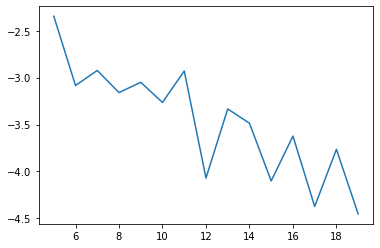

In [12]:
import pandas as pd 

from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

max_num_topics =20

results = []

for t in range(5, max_num_topics):
    lda_model = train_lda(num_top=t, corpus=corpus, d=dictionary)
    corpus_lda = lda_model[corpus]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    results.append(tup)

results = pd.DataFrame(results, columns=['topic', 'score'])
s = pd.Series(results.score.values, index=results.topic.values)
_ = s.plot()

## Evaluating Output

### Output 1:  Inspecting Topics Lists

Below we create a topic model with eleven topics and then print off the top ten words in each topic.  As an unsupervised learning technique, you should not expect perfect scrutability of the output. Looking the below I might assign the following topic labels: 

1.  Audio Streaming
2.  Donald Trump 
3.  Facebook Friends of Friends
4.  Second Amendment 
5.  African American Politics 
6.  Civil Rights Movement 
7.  Islam 
8.  Civil Rights Movement (2) 
9.  US Policing 
10. LGBT/Liberal Politics 
11. Black Power Movement 

Generally, it is helpful to have some domain knowledge.  For example, topic one looks like garbage unless you know that [the Russians were promoting a Chrome extension for audio streaming](https://www.wired.com/story/russia-facebook-ads-sketchy-chrome-extension/) which if installed spammed the Facebook friends of a user with, presumably, propaganda.  The point is that even if a topic appears to not make sense, it usually bears some cursory examination.      

In [9]:
from gensim import matutils 

model = train_lda(num_top=11, corpus=corpus, d=dictionary)

# Provides a convenient human readable list of topic terms. 
for i in range(model.num_topics): 
    terms = model.get_topic_terms(i, topn=10)
    term_lst = []
    for j in terms: 
        term_lst.append(model.id2word[j[0]])
    term_lst = (", ").join(term_lst)
    print('Topic {}: '.format(i+1), term_lst)
    
# Creating an accessible Document X Topic matrix. 
docTopicProbMat = model[corpus]
dtm = matutils.corpus2dense(docTopicProbMat, model.num_topics, len(docTopicProbMat)).transpose()

Topic 1:  music, soundcloud, fm, last, facebook_access, browser, access, facebook, grooveshark, grooveshark_last
Topic 2:  jesus, trump, donald, donald_trump, presid, parti, conserv, jr, baptism, king
Topic 3:  polit, friend_peopl, connect, friend, peopl, polit_conserv, conserv, us, gun, amend
Topic 4:  gun, veteran, right, america, amend, second, second_amend, associ, gun_owner, owner
Topic 5:  us, veteran, american, african, african_american, polit, black, voic, liber, polit_content
Topic 6:  africanamerican, king, martin, martin_luther, luther, king_jr, jr, histori, black, movement
Topic 7:  islam, muslim, patriot, american, america, cultur, state, parti, histori, unit
Topic 8:  american, african_american, african, movement, us, cultur, nation, civil, histori, right
Topic 9:  state, unit, unit_state, polic, america, nation, parti, gun, stop, associ
Topic 10:  lgbt, social, communiti, immigr, justic, right, movement, cultur, stop, histori
Topic 11:  black, power, histori, cop, panthe

#### Getting a Selection of Documents for Each Topic

I've defined some functions that allow us to print a subset of untokenized documents for each topic. Note that you can set the number of documents it returns as well as the threshold for the topic score.  Higher thresholds mean that the document focuses more on a given topic (i.e., it's a purer representation of that topic).  The reason that we do this is to assist in interpretability - it can be easier to spot the commonalities in documents when looking at untokenized documents that are strong matches for a given topic.

In [10]:
def get_indices_for_topic(col, threshold, dtm):
    """
    Args: 
        col (int): Column index. 
        threshold (float): Value above which indices should be returned.\
        dtm (ndarray): Document X topic matrix.
    
    Return: 
        lst of ints: Indices that exceed threshold. 
    """
    topic = dtm[:,col]
    indices = [i[0] for i in np.argwhere(topic > threshold).tolist()]
    return indices    


def view_docs_by_topic(dtm, threshold, d, num_return=None):
    """
    Returns a selection of documents which topic scores exceeding threshold. 
    
    Args: 
        dtm (ndarray): Document X topic matrix.
        threshold (float): Topic score threshold above which documents should 
                           be returned. 
        d (lst of str): List of untokenized documents.  
        num_return (int): Number of documents to return for each topic. 
    
    Returns: 
        str: Selection of original docs with topic scores exceeding threshold.
    """
    output = ""
    for i in range(dtm.shape[1]):
        indices = get_indices_for_topic(i, threshold, dtm)
        selected_docs = [d[j] for j in indices] 
        output += "*** Topic #{} ***\n\n".format(i+1)
        for s_d in selected_docs[:num_return]: 
            output += s_d + "\n"
        output += "\n"
    return output


number_of_docs =10
threshold = .7
print(view_docs_by_topic(dtm, threshold, orig_docs, number_of_docs))

*** Topic #1 ***

African American (US) On Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music US politics (conservative) 
Hotep, Nelson Mandela, Kemetism, Kwame Nkrumah, Afrocentrism, Marcus Garvey or Nigeria On Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music US politics (conservative) 
jesus love u or I Have Decided to Follow Jesus On Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music US politics (conservative) 
Mexico, Latin hip hop, Chicano Movement, Hispanidad, Lowrider or Chicano rap On Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music US politics (conservative) 
Facebook access (browser): Chrome Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music 
Interests Free software Facebook access (browser): Chrome 
 Facebook access (browser): Chrome Free software 
Facebook access (browser): Chrome Music, Last.fm, SoundCloud or Apple Music 
Facebook acces

### Output 2: Inspecting the Document X Topic Matrix 
Remember that each document (i.e., a Facebook ad's targeting criteria) is a mix of all topics in LDA!  This makes intuitive sense.  Afterall, you can target someone how engages with content representing a mix of the topics above (e.g., you can imagine a segment that cares about both US policing and civil rights).  

Our Document X Topic matrix (i.e., dtm) has a row for each document (in this case a Facebook ad) and a column for each topic.  The values for a given row represent the percent each topic is present in that document.  Intuitively, if you sum across the topics, you should get approximately 1.00 or 100% (plus or minus some rounding). In contrast, when you sum the columns of the documents (i.e., the topics) it is not immediately interpretable. However, we can convert this to a percent value by dividing it by the number of documents.  This tells us the percentage to which each topic was discussed in the corpus.  This is useful if you want to visualize the prevalence of topics in a document or the corpus.  

If you want the number of documents for each topic you must set a threshold and then count the number of documents whose score exceeds it. For example, if you set a value of .33 (i.e., 33 percent allocation to a given topic) then documents can at most be bucketed into 3 topics but probably no more than 2.  However, some documents are never going to reach that threshold for any topic. In other words, the counts will not equal the total of your sample.

In [11]:
print("Note that the row sums are approximately 1: \n", 
      np.around(dtm.sum(axis=1)[:10], decimals=2))

print("\nNote that raw column sums only allow for ordinal ranking: \n", 
     np.around(dtm.sum(axis=0), decimals=2))


print("\nNote that dividing column marginals by the number of documents " \
      "gives you the topic percentages within the corpus: \n" , 
      np.around(np.true_divide(dtm.sum(axis=0), dtm.shape[0]),
      decimals=2))


print("\nAs expected topic percentages within the corpus sum to ~ 1: ", 
     np.around(sum(np.true_divide(dtm.sum(axis=0), sum(dtm.sum(axis=1)))), 
              decimals=2))



Note that the row sums are approximately 1: 
 [0.98 0.98 0.98 0.97 1.   0.97 0.95 0.95 0.98 0.94]

Note that raw column sums only allow for ordinal ranking: 
 [20.38 13.79 15.39 21.69 39.74 48.78 17.01 23.7  26.83 17.75 32.91]

Note that dividing column marginals by the number of documents gives you the topic percentages within the corpus: 
 [0.07 0.05 0.05 0.08 0.14 0.17 0.06 0.08 0.09 0.06 0.12]

As expected topic percentages within the corpus sum to ~ 1:  1.0


## Conclusion

In this post we've demonstrated how to create and evaluate topic models. I've also provided guidance regarding how to interpret the output of such models. However, you can go even further! For example, using our list of dictionary keys we can join this back to the original dataset and inspect the ads start and end dates to learn how the Russian ad targeting evolved over time. We can also look at which topics received the most engagement by users, what the Russian ad spend was on each topic, or even what the ROI was (they spent shockingly little)! And, of course, we can create visualizations for all of this.

I haven't forgotten that we started this series explaining how we analyzed open responses to a client’s survey. To be clear I used similar techniques to do so. Specifically, I pooled similar questions together since open responses are short, I checked for duplicates to eliminate spam, and I used topic coherence to suggest how many topics were present. Our results provided value to our client that they would not have gotten by simply cherry-picking answers from the survey. Not only did they learn thematically what their consumers were saying but they learned the prevalence of those themes in the responses.

If you'd like assistance analyzing open-survey responses, consumer social media posts, or any body of text, please feel free to reach out to Evolytics for assistance.